### Train model on AWS SageMaker

Our aim is to train a NN model on AWS SageMaker using script model



In [ ]:
import os
import keras
import numpy as np
from keras.datasets import fashion_mnist

(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

We create a local directory and save the training and test data seoerately

In [32]:
os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_val, label=y_val)

### Train on AWS SageMaker


In [2]:
import sagemaker

print(sagemaker.__version__)
sess = sagemaker.Session()
role = sagemaker.get_execution_role()


1.71.0


In [3]:
from sagemaker.tensorflow import TensorFlow
tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn.py',
                         role = role, 
                         train_instance_count = 1,
                         train_instance_type ='local',
                         framework_version = '1.15',
                         py_version ='py3',
                         script_mode =True,
                         hyperparameters={'epochs':1})
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'


Train the model on Sage Maker

In [4]:
tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmp_gvlko7e_algo-1-ewxar_1 ... 
Attaching to tmp_gvlko7e_algo-1-ewxar_12mdone
algo-1-ewxar_1  | WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
algo-1-ewxar_1  | 
algo-1-ewxar_1  | 2020-08-14 02:53:44,336 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-ewxar_1  | 2020-08-14 02:53:44,342 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-ewxar_1  | 2020-08-14 02:53:44,596 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-ewxar_1  | 2020-08-14 02:53:44,613 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-ewxar_1  | 2020-08-14 02:53:44,629 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-ewxar_1  | 2020-08-14 02:53:44,640 sagema

algo-1-ewxar_1  | Collecting keras-metrics
algo-1-ewxar_1  |   Downloading keras_metrics-1.1.0-py2.py3-none-any.whl (5.6 kB)
algo-1-ewxar_1  | Requirement already satisfied: Keras>=2.1.5 in /usr/local/lib/python3.6/dist-packages (from keras-metrics) (2.3.1)
algo-1-ewxar_1  | Requirement already satisfied: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.19.1)
algo-1-ewxar_1  | Requirement already satisfied: scipy>=0.14 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.2.2)
algo-1-ewxar_1  | Requirement already satisfied: pyyaml in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (5.3.1)
algo-1-ewxar_1  | Requirement already satisfied: keras-preprocessing>=1.0.5 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.1.2)
algo-1-ewxar_1  | Requirement already satisfied: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from Keras>=2.1.5->keras-metrics) (1.15.0)


# Upload the dataset to S3

We could use boto3, on SageMaker SDK a simple way is to use Session.upload_data()

In [5]:
prefix = 'keras-mnist-fashion'

training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

print(training_input_path)
print(test_input_path)

s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/training/training.npz
s3://sagemaker-us-east-2-920448009623/keras-mnist-fashion/validation/test.npz


# Train with managed instances

Used [managed spot instance](https://aws.amazon.com/blogs/aws/managed-spot-training-save-up-to-90-on-your-amazon-sagemaker-training-jobs/) to save money 

In [37]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs

tf_estimator = TensorFlow(entry_point='mnist_fashion_vnn.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.m4.xlarge',
                          framework_version='1.15', 
                          py_version='py3',
                          script_mode=True,
                          train_use_spot_instances=True,        # Use spot instance
                          train_max_run=3600,                    # Max training time
                          train_max_wait=7200,                  # Max training time + spot waiting time
                          rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
                                   Rule.sagemaker(rule_configs.overfit())]
                         )


In [38]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-11 01:57:12 Starting - Starting the training job...
2020-08-11 01:57:37 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*            Overfit: InProgress        
*
****************************************
.........
2020-08-11 01:59:09 Starting - Preparing the instances for training......
2020-08-11 01:59:59 Downloading - Downloading input data...
2020-08-11 02:00:39 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-08-11 02:00:43,127 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-08-11 02:00:43,134 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-08-11 02:00:43,578 sagemaker-training-toolkit INFO   

#015  128/60000 [..............................] - ETA: 2:44 - loss: 2.4208 - acc: 0.1172 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1536/60000 [..............................] - ETA: 15s - loss: 2.1742 - acc: 0.1680 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  128/60000 [..............................] - ETA: 2s - loss: 0.3965 - acc: 0.8984 - precision: 0.9231 - recall: 0.7500 - f1_score: 0.8276#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1920/60000 [..............................] - ETA: 1s - loss: 0.3962 - acc: 0.8620 - precision: 0.8379 - recall: 0.7906 - f1_score: 0.7981#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0


2020-08-11 02:01:40 Uploading - Uploading generated training model
2020-08-11 02:01:40 Completed - Training job completed
#015  128/60000 [..............................] - ETA: 3s - loss: 0.3656 - acc: 0.8594 - precision: 0.6667 - recall: 0.4615 - f1_score: 0.5455#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1792/60000 [..............................] - ETA: 1s - loss: 0.3172 - acc: 0.8789 - precision: 0.8500 - recall: 0.8005 - f1_score: 0.8180#010#010#010#010#010#010#010#010#01

Training seconds: 87
Billable seconds: 19
Managed Spot Training savings: 78.2%


# Deploy the code


In [20]:
%%sh
python3 -m pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2


In [ ]:
import time

# Deploy the model to an endpoint backed by a single c5.large instance,
# accelerated by a medium-size elastic inference accelerator

tf_endpoint_name = 'keras-tf-fmnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge', # $0.28/hour in eu-west-1
                                   endpoint_name=tf_endpoint_name)    

# Delete the endpoint


Predicted labels are: [3 3 2 0 1 0 8 0 1 6]


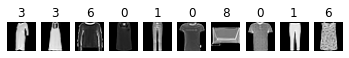

In [24]:
 %matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 10
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = best_model_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_labels = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_labels))

In [25]:
best_model_predictor.delete_endpoint()